In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformaciones para CIFAR-100
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Cargar el dataset CIFAR-100
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Mapear las clases del dataset a nombres
classes = {
    0: 'apple', 1: 'aquarium_fish', 2: 'baby', 3: 'bear', 4: 'beaver', 5: 'bed', 6: 'bee',
    7: 'beetle', 8: 'bicycle', 9: 'bottle', 10: 'bowl', 11: 'boy', 12: 'bridge', 13: 'bus',
    14: 'butterfly', 15: 'camel', 16: 'can', 17: 'castle', 18: 'caterpillar', 19: 'cattle',
    20: 'chair', 21: 'chimpanzee', 22: 'clock', 23: 'cloud', 24: 'cockroach', 25: 'couch',
    26: 'crab', 27: 'crocodile', 28: 'cup', 29: 'dinosaur', 30: 'dolphin', 31: 'elephant',
    32: 'flatfish', 33: 'forest', 34: 'fox', 35: 'girl', 36: 'hamster', 37: 'house', 38: 'kangaroo',
    39: 'keyboard', 40: 'lamp', 41: 'lawn_mower', 42: 'leopard', 43: 'lion', 44: 'lizard',
    45: 'lobster', 46: 'man', 47: 'maple_tree', 48: 'motorcycle', 49: 'mountain', 50: 'mouse',
    51: 'mushroom', 52: 'oak_tree', 53: 'orange', 54: 'orchid', 55: 'otter', 56: 'palm_tree',
    57: 'pear', 58: 'pickup_truck', 59: 'pine_tree', 60: 'plain', 61: 'plate', 62: 'poppy',
    63: 'porcupine', 64: 'possum', 65: 'rabbit', 66: 'raccoon', 67: 'ray', 68: 'road', 69: 'rocket',
    70: 'rose', 71: 'sea', 72: 'seal', 73: 'shark', 74: 'shrew', 75: 'skunk', 76: 'skyscraper',
    77: 'snail', 78: 'snake', 79: 'spider', 80: 'squirrel', 81: 'streetcar', 82: 'sunflower',
    83: 'sweet_pepper', 84: 'table', 85: 'tank', 86: 'telephone', 87: 'television', 88: 'tiger',
    89: 'tractor', 90: 'train', 91: 'trout', 92: 'tulip', 93: 'turtle', 94: 'wardrobe',
    95: 'whale', 96: 'willow_tree', 97: 'wolf', 98: 'woman', 99: 'worm'
}

# Elegir categorías específicas
categories = {
    "spiders": 79,  # Arañas
}

# Función para filtrar índices por clase
def filter_indices_by_class(dataset, target_class):
    indices = []
    for idx, (_, label) in enumerate(dataset):
        if label == target_class:
            indices.append(idx)
    return indices

# Filtrar índices para cada categoría
spider_indices = filter_indices_by_class(test_dataset, categories["spiders"])
people_indices = filter_indices_by_class(test_dataset, categories["people"])
tree_indices = filter_indices_by_class(test_dataset, categories["trees"])

# Seleccionar 5 ejemplos aleatorios de cada categoría
selected_indices = (
    np.random.choice(spider_indices, size=5, replace=False).tolist() +
    np.random.choice(people_indices, size=5, replace=False).tolist() +
    np.random.choice(tree_indices, size=5, replace=False).tolist()
)

# Crear DataLoader para ejemplos seleccionados
example_loader = DataLoader(
    torch.utils.data.Subset(test_dataset, selected_indices),
    batch_size=len(selected_indices),
    shuffle=False
)

# Obtener imágenes y etiquetas de los ejemplos seleccionados
example_images, example_labels = next(iter(example_loader))
example_images = example_images.numpy()

# Calcular distancias en el espacio de píxeles
distances = euclidean_distances(example_images.reshape(len(example_images), -1))
knn_indices = np.argsort(distances, axis=1)[:, :6]  # Los 5 vecinos más cercanos (incluyendo la consulta)

# Función para graficar los 5 vecinos más cercanos en 3 filas (una por categoría)
# Función para graficar los vecinos con la consulta en la primera columna
def plot_query_with_neighbors(images, knn_indices, labels, categories, title, k=5):
    """
    Muestra la consulta y sus 5 vecinos más cercanos en una fila por categoría.
    """
    num_categories = len(categories)
    fig, axes = plt.subplots(num_categories, k + 1, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)

    for row_idx, (category_name, category_label) in enumerate(categories.items()):
        # Filtrar ejemplos de la categoría actual
        category_indices = [i for i in range(len(labels)) if labels[i].item() == category_label]
        if not category_indices:
            print(f"No examples found for category: {category_name}")
            continue

        # Usar el primer ejemplo de la categoría como consulta
        query_idx = category_indices[0]
        neighbors = knn_indices[query_idx][1:k + 1]  # Los 5 vecinos más cercanos

        # Graficar la consulta
        axes[row_idx, 0].imshow(np.transpose(images[query_idx], (1, 2, 0)))
        axes[row_idx, 0].set_title(f"Query ({category_name})", fontsize=10)
        axes[row_idx, 0].axis("off")

        # Graficar los vecinos
        for col_idx, neighbor_idx in enumerate(neighbors):
            axes[row_idx, col_idx + 1].imshow(np.transpose(images[neighbor_idx], (1, 2, 0)))
            neighbor_label = int(labels[neighbor_idx].item())  # Convertir tensor a entero
            neighbor_name = classes[neighbor_label]
            axes[row_idx, col_idx + 1].set_title(f"Neighbor {col_idx + 1} ({neighbor_name})", fontsize=10)
            axes[row_idx, col_idx + 1].axis("off")

    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Graficar la consulta y los vecinos para las categorías seleccionadas
categories_ordered = {"spiders": 79, "people": 46, "trees": 47}  # Categorías y etiquetas
plot_query_with_neighbors(example_images, knn_indices, example_labels, categories_ordered, "Query and 5 Nearest Neighbors", k=5)


Files already downloaded and verified


KeyError: 'people'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


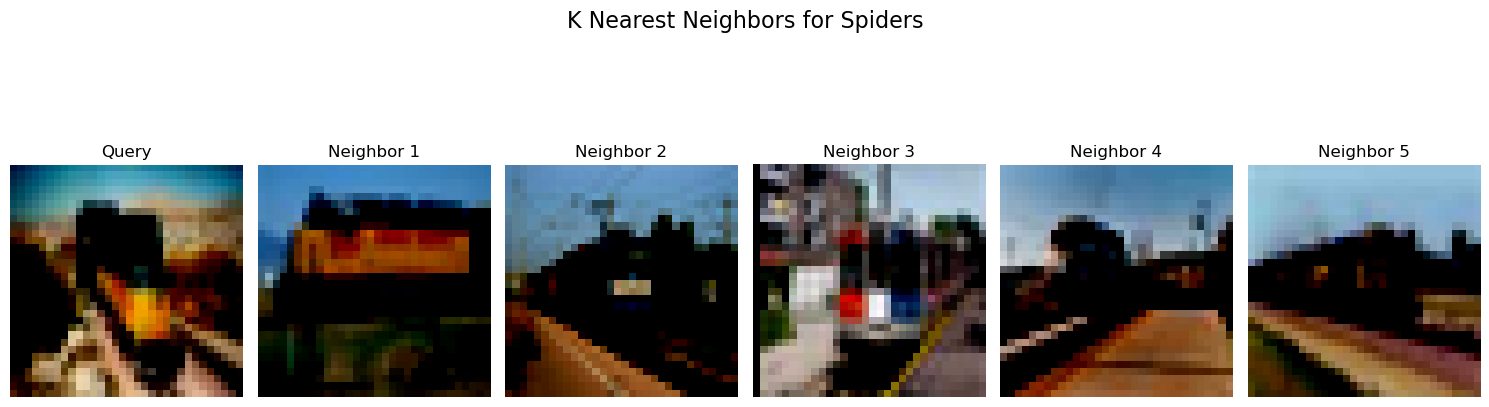

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

# Función para filtrar índices por clase
def filter_indices_by_class(dataset, target_class):
    """
    Filtra los índices de las imágenes que pertenecen a la clase deseada.
    """
    indices = []
    for idx, (_, label) in enumerate(dataset):
        if label == target_class:
            indices.append(idx)
    return indices

# Función para calcular los vecinos más cercanos
def calculate_knn_for_class(dataset, class_label, k=5):
    """
    Calcula los k vecinos más cercanos en el espacio de píxeles para una clase específica.
    """
    # Filtrar los índices de la clase deseada
    class_indices = filter_indices_by_class(dataset, class_label)
    if not class_indices:
        raise ValueError(f"No examples found for class {class_label}")

    # Cargar imágenes de la clase
    class_images = [dataset[idx][0].numpy() for idx in class_indices]
    class_images = np.array(class_images)

    # Calcular distancias en el espacio de píxeles
    distances = euclidean_distances(class_images.reshape(len(class_images), -1))

    # Encontrar los k vecinos más cercanos para cada imagen
    knn_indices = np.argsort(distances, axis=1)[:, :k + 1]  # Incluye la consulta como primer vecino

    return class_indices, knn_indices, class_images

# Función para mostrar los vecinos más cercanos
def plot_knn_images(class_images, knn_indices, title="K Nearest Neighbors", k=5):
    """
    Muestra la consulta y sus k vecinos más cercanos.
    """
    query_idx = 0  # Usar la primera imagen como consulta
    neighbors = knn_indices[query_idx]  # Vecinos de la consulta

    # Crear figura
    fig, axes = plt.subplots(1, k + 1, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)

    # Graficar la consulta
    axes[0].imshow(np.transpose(class_images[neighbors[0]], (1, 2, 0)))
    axes[0].set_title("Query", fontsize=12)
    axes[0].axis("off")

    # Graficar los vecinos
    for i, neighbor_idx in enumerate(neighbors[1:], start=1):
        axes[i].imshow(np.transpose(class_images[neighbor_idx], (1, 2, 0)))
        axes[i].set_title(f"Neighbor {i}", fontsize=12)
        axes[i].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Ejemplo de uso
class_label = 90  # Clase 
k = 5

# Calcular los vecinos más cercanos para la clase
class_indices, knn_indices, class_images = calculate_knn_for_class(test_dataset, class_label, k=k)

# Mostrar las imágenes
plot_knn_images(class_images, knn_indices, title="K Nearest Neighbors for Spiders", k=5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


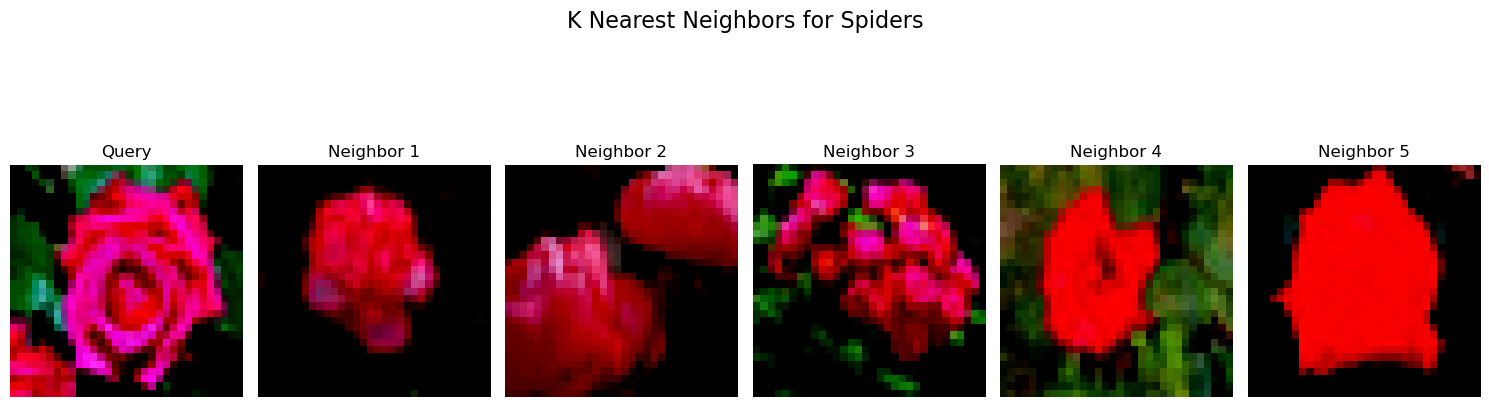

In [18]:
# Ejemplo de uso
class_label = 70  # Clase 
k = 5

# Calcular los vecinos más cercanos para la clase
class_indices, knn_indices, class_images = calculate_knn_for_class(test_dataset, class_label, k=k)

# Mostrar las imágenes
plot_knn_images(class_images, knn_indices, title="K Nearest Neighbors for Spiders", k=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


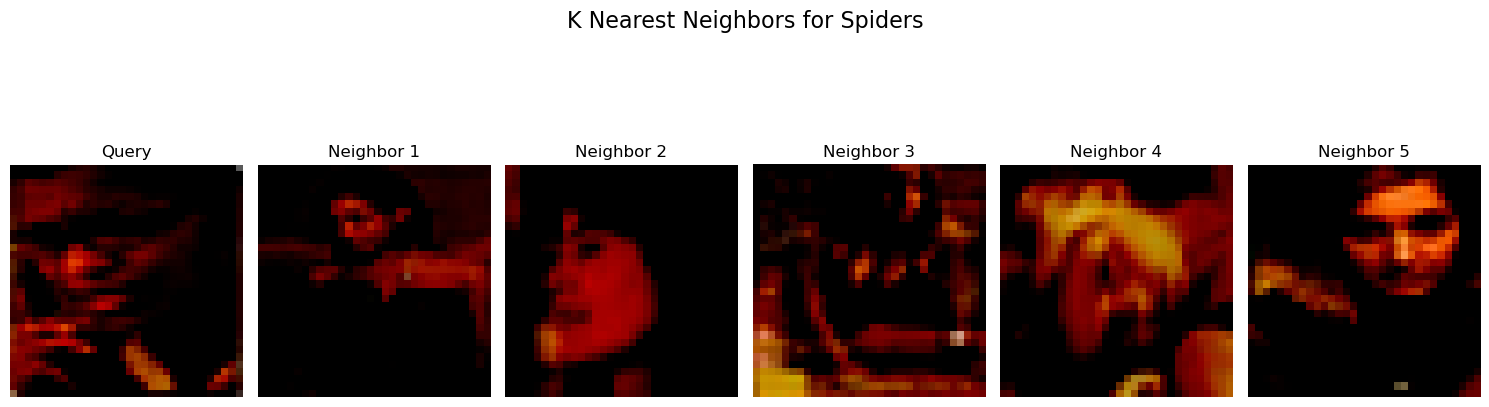

In [19]:
# Ejemplo de uso
class_label = 98  # Clase 
k = 5

# Calcular los vecinos más cercanos para la clase
class_indices, knn_indices, class_images = calculate_knn_for_class(test_dataset, class_label, k=k)

# Mostrar las imágenes
plot_knn_images(class_images, knn_indices, title="K Nearest Neighbors for Spiders", k=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


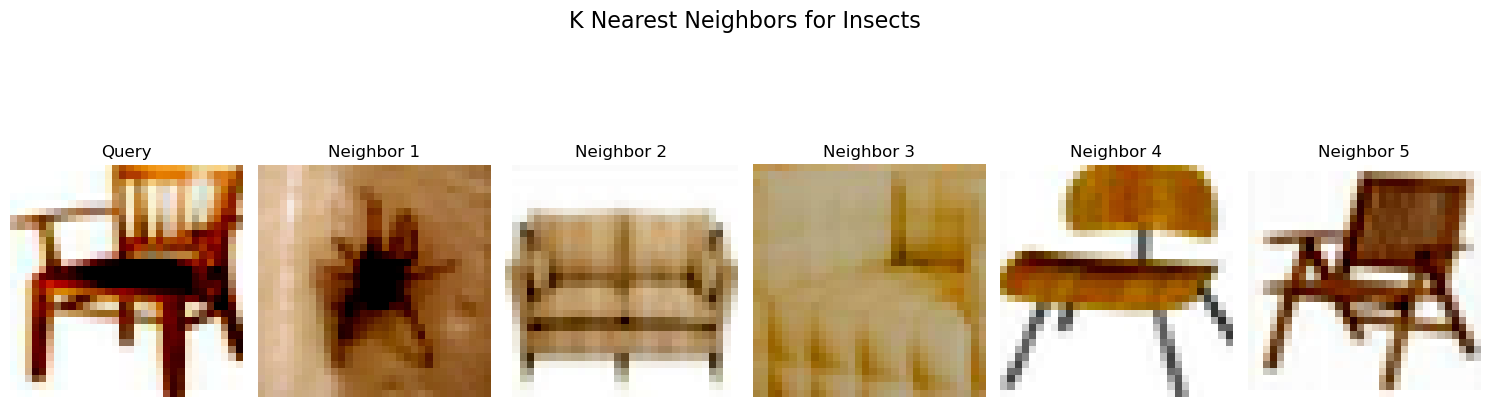

In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

# Diccionario que mapea las clases a las superclases
superclass_map = {
    0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7, 8: 18, 9: 3, 10: 3,
    11: 14, 12: 9, 13: 18, 14: 7, 15: 11, 16: 3, 17: 9, 18: 7, 19: 11, 20: 6,
    21: 11, 22: 5, 23: 10, 24: 7, 25: 6, 26: 13, 27: 15, 28: 3, 29: 15, 30: 0,
    31: 11, 32: 1, 33: 10, 34: 12, 35: 14, 36: 16, 37: 9, 38: 11, 39: 5, 40: 5,
    41: 19, 42: 8, 43: 8, 44: 15, 45: 13, 46: 14, 47: 17, 48: 18, 49: 10, 50: 16,
    51: 4, 52: 17, 53: 4, 54: 2, 55: 0, 56: 17, 57: 4, 58: 18, 59: 17, 60: 10,
    61: 3, 62: 2, 63: 12, 64: 12, 65: 16, 66: 12, 67: 1, 68: 9, 69: 19, 70: 2,
    71: 10, 72: 15, 73: 5, 74: 19, 75: 2, 76: 19, 77: 18, 78: 1, 79: 6, 80: 1,
    81: 10, 82: 17, 83: 12, 84: 16, 85: 19, 86: 2, 87: 4, 88: 6, 89: 5, 90: 0,
    91: 17, 92: 8, 93: 14, 94: 13, 95: 19, 96: 18, 97: 0, 98: 16, 99: 13
}

# Función para filtrar índices por superclase
def filter_indices_by_superclass(dataset, target_superclass):
    """
    Filtra los índices de las imágenes que pertenecen a la superclase deseada.
    """
    indices = []
    for idx, (_, label) in enumerate(dataset):
        if superclass_map[label] == target_superclass:
            indices.append(idx)
    return indices

# Función para calcular los vecinos más cercanos
def calculate_knn_for_superclass(dataset, superclass_label, k=5):
    """
    Calcula los k vecinos más cercanos en el espacio de píxeles para una superclase específica.
    """
    # Filtrar los índices de la superclase deseada
    superclass_indices = filter_indices_by_superclass(dataset, superclass_label)
    if not superclass_indices:
        raise ValueError(f"No examples found for superclass {superclass_label}")

    # Cargar imágenes de la superclase
    superclass_images = [dataset[idx][0].numpy() for idx in superclass_indices]
    superclass_images = np.array(superclass_images)

    # Calcular distancias en el espacio de píxeles
    distances = euclidean_distances(superclass_images.reshape(len(superclass_images), -1))

    # Encontrar los k vecinos más cercanos para cada imagen
    knn_indices = np.argsort(distances, axis=1)[:, :k + 1]  # Incluye la consulta como primer vecino

    return superclass_indices, knn_indices, superclass_images

# Función para mostrar los vecinos más cercanos
def plot_knn_images(superclass_images, knn_indices, title="K Nearest Neighbors", k=5):
    """
    Muestra la consulta y sus k vecinos más cercanos.
    """
    query_idx = 0  # Usar la primera imagen como consulta
    neighbors = knn_indices[query_idx]  # Vecinos de la consulta

    # Crear figura
    fig, axes = plt.subplots(1, k + 1, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)

    # Graficar la consulta
    axes[0].imshow(np.transpose(superclass_images[neighbors[0]], (1, 2, 0)))
    axes[0].set_title("Query", fontsize=12)
    axes[0].axis("off")

    # Graficar los vecinos
    for i, neighbor_idx in enumerate(neighbors[1:], start=1):
        axes[i].imshow(np.transpose(superclass_images[neighbor_idx], (1, 2, 0)))
        axes[i].set_title(f"Neighbor {i}", fontsize=12)
        axes[i].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Ejemplo de uso
superclass_label = 6  # Superclase de insectos (insects)
k = 5

# Calcular los vecinos más cercanos para la superclase
superclass_indices, knn_indices, superclass_images = calculate_knn_for_superclass(test_dataset, superclass_label, k=k)

# Mostrar las imágenes
plot_knn_images(superclass_images, knn_indices, title="K Nearest Neighbors for Insects", k=5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


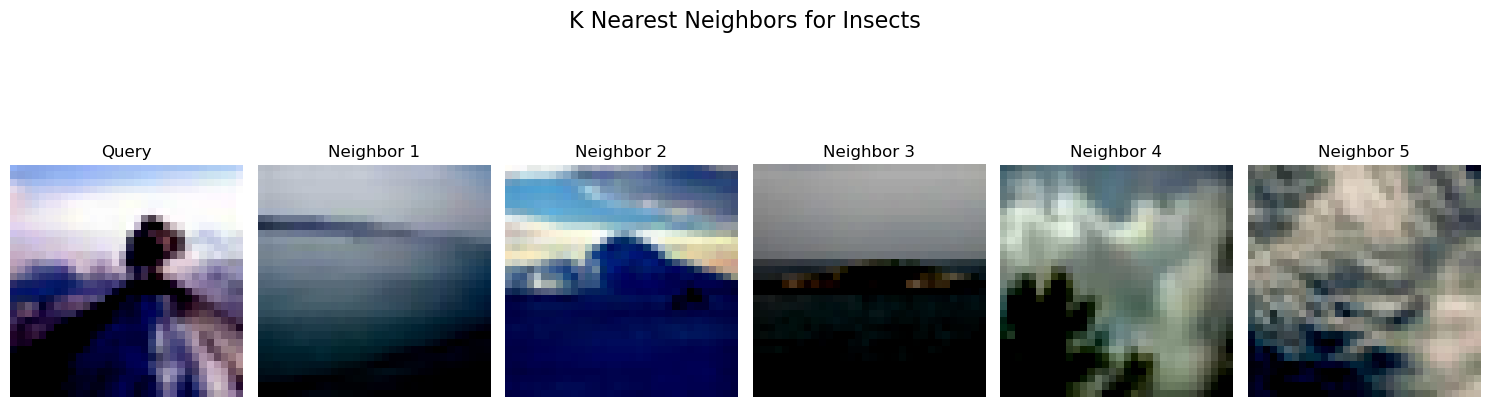

In [30]:
# Ejemplo de uso
superclass_label = 10  # Superclase de insectos (insects)
k = 5

# Calcular los vecinos más cercanos para la superclase
superclass_indices, knn_indices, superclass_images = calculate_knn_for_superclass(test_dataset, superclass_label, k=k)

# Mostrar las imágenes
plot_knn_images(superclass_images, knn_indices, title="K Nearest Neighbors for Insects", k=5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


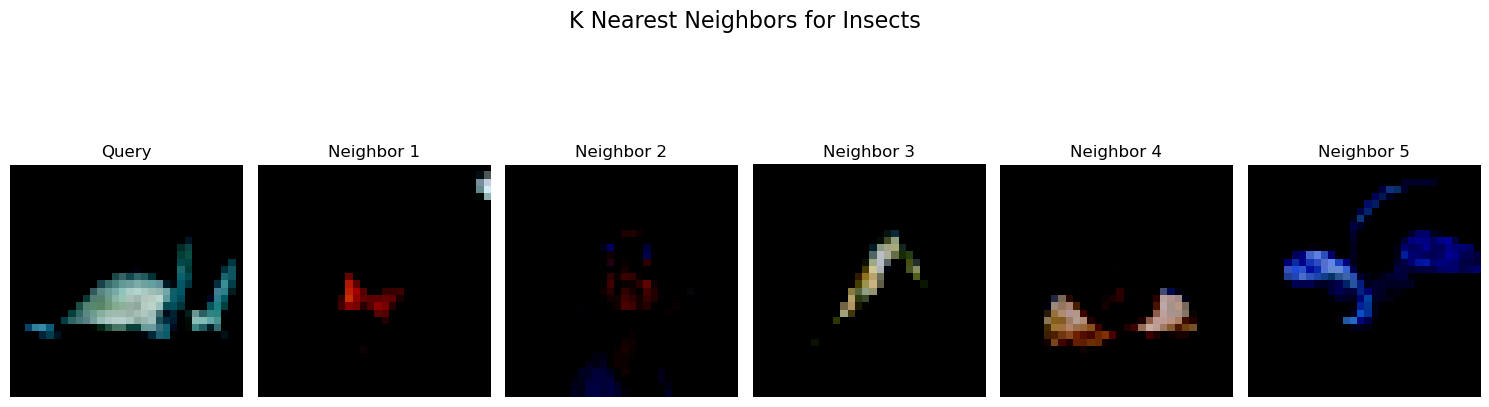

In [54]:
# Ejemplo de uso
superclass_label = 14  # Superclase de insectos (insects)
k = 5

# Calcular los vecinos más cercanos para la superclase
superclass_indices, knn_indices, superclass_images = calculate_knn_for_superclass(test_dataset, superclass_label, k=k)

# Mostrar las imágenes
plot_knn_images(superclass_images, knn_indices, title="K Nearest Neighbors for Insects", k=5)
